In [1]:
!which python

/home/vectech4/anaconda3/envs/myenv/bin/python


In [2]:

from fastai.vision.all import *
from torch import nn

from fastai.callback.hook import summary
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets, DataLoaders, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, parent_label, ToTensor, IntToFloatTensor, Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy, CrossEntropyLossFlat

from fastai.vision.augment import CropPad, RandomCrop, PadMode
from fastai.vision.core import PILImageBW
from fastai.vision.utils import get_image_files

/home/vectech4/anaconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = untar_data(URLs.PETS)
items = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

In [4]:
items[0]

Path('/home/vectech4/.fastai/data/oxford-iiit-pet/images/pug_176.jpg')

In [5]:
im = PILImage.create(items[0])

<Axes: >

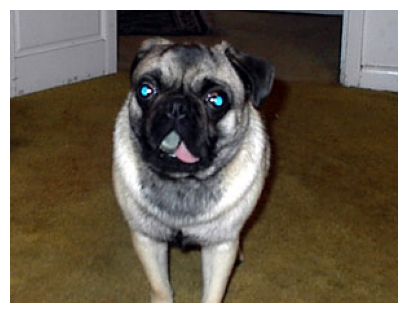

In [6]:
im.show()

In [7]:
im.shape

(227, 300)

In [8]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=500

In [9]:
dls = ImageDataLoaders.from_name_re(path, items, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

In [10]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)


In [11]:
path_im = path/'images'

In [12]:
dls = pets.dataloaders(path_im, bs=bs)

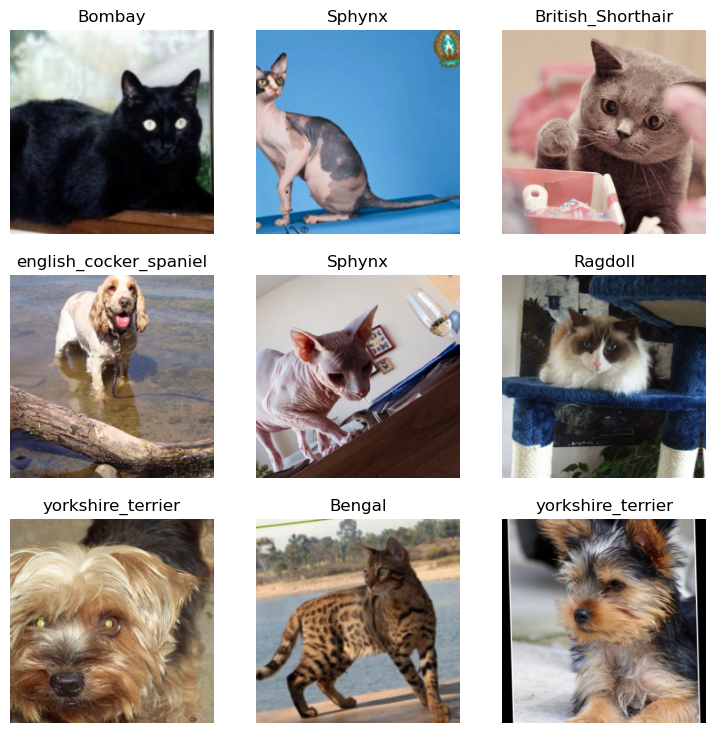

In [13]:
dls.show_batch()

In [14]:
xb, yb = dls.one_batch()

In [15]:
xb.shape, yb.shape

(torch.Size([500, 3, 224, 224]), torch.Size([500]))

In [16]:
dls.c

37

In [17]:
from pytorch_pretrained_vit import ViT
model = ViT('B_16_imagenet1k', pretrained=True)
model.cuda()

Loaded pretrained weights.


ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
 

In [18]:
from torchvision.models.resnet import resnet34, resnet50
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()
learn.cuda()

/home/vectech4/anaconda3/envs/myenv/lib/python3.11/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
learn.summary()

Sequential (Input shape: 500 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     500 x 64 x 112 x 11 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     500 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

SuggestedLRs(valley=0.0006918309954926372)

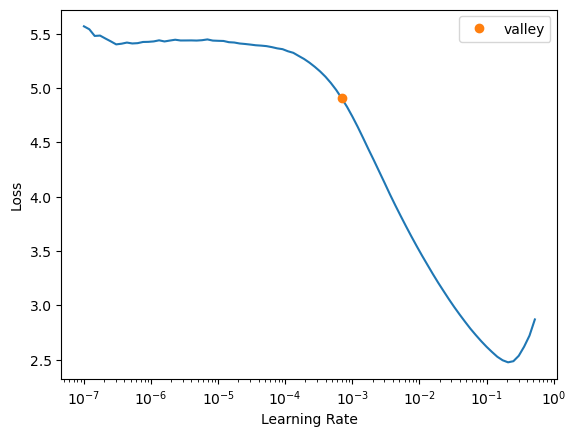

In [20]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(60, lr_max=1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,1.228195,0.694485,0.151556,00:10


In [ ]:
from torch.utils import collect_env
collect_env.main()